In [42]:
import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

In [35]:
class MyDataset(Dataset):
    def __init__(self, ai_path, real_path, img_size=(224, 224)):
        
        ai_images = [(p, 1) for p in glob.glob(ai_path)]
        real_images = [(p, 0) for p in glob.glob(real_path)]
        self.all_data = ai_images + real_images

        random.seed(42)
        random.shuffle(self.all_data)
        
        self.img_size = img_size
        
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.4590, 0.4276, 0.3941], std=[0.2535, 0.2327, 0.2276])
        ])
    
    def __len__(self):
        return len(self.all_data)
    
    def __getitem__(self, idx):
        file_path, label = self.all_data[idx]
        
        img = Image.open(file_path).convert("RGB")
        img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.float32)

def get_dataloaders(ai_path, real_path, img_size=(224, 224), batch_size=32, val_split=0.2):

    dataset = MyDataset(ai_path, real_path, img_size)
    
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader

if __name__ == '__main__':
    ai_path = "./AI-Generated-vs-Real-Images-Datasets/AiArtData/AiArtData/*"
    real_path = "./AI-Generated-vs-Real-Images-Datasets/RealArt/RealArt/*"

    train_loader, val_loader = get_dataloaders(ai_path, real_path, img_size=(224, 224), batch_size=32, val_split=0.2)


/Users/daniyar/notes/projects/ai_image_detector/env/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


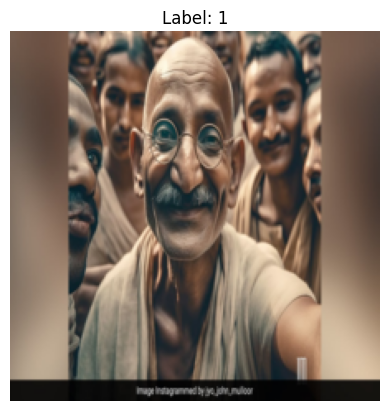

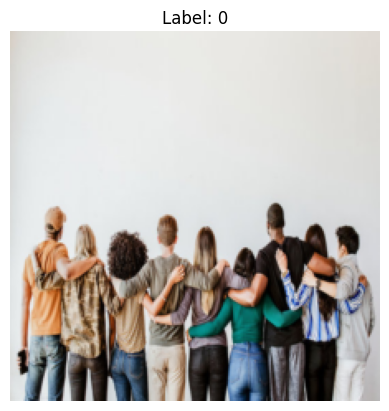

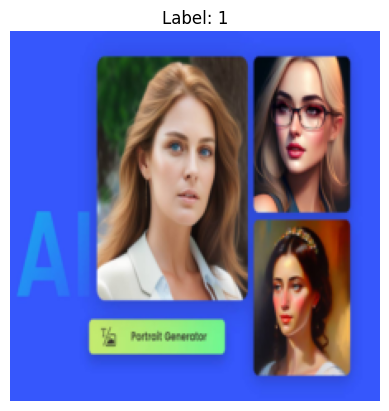

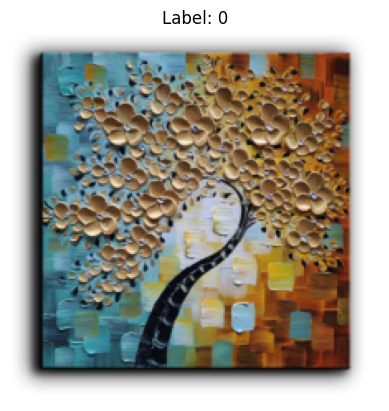

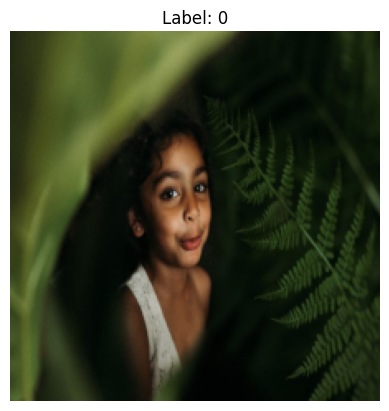

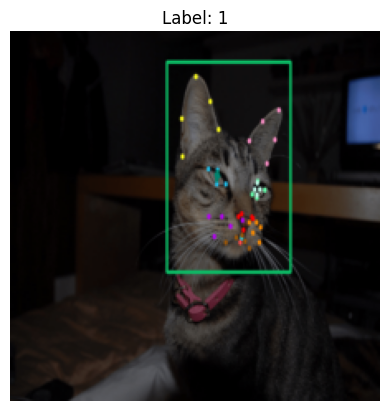

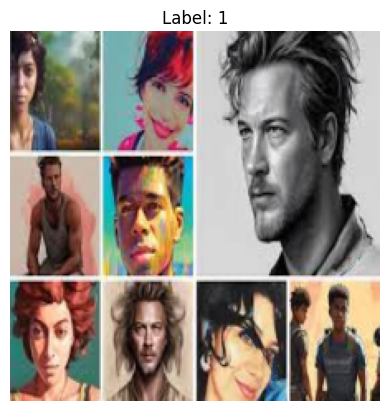

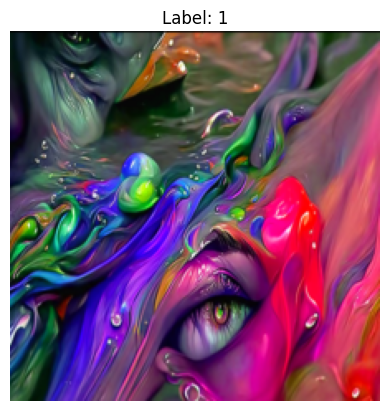

In [36]:
def show_image(img_tensor, label=None):
    transform_to_pil = transforms.ToPILImage()
    img = transform_to_pil(img_tensor)
    
    plt.imshow(img)
    if label is not None:
        plt.title(f"Label: {int(label)}")
    plt.axis('off')
    plt.show()

for images, labels in train_loader:
    for i in range(8):
        show_image(images[i], labels[i])
    break


In [ ]:
class PretrainedResNet(nn.Module):
    def __init__(self):
        super(PretrainedResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)  # Загрузим ResNet50
        num_features = self.base_model.fc.in_features  # Количество выходных признаков
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.base_model(x)


model = PretrainedResNet()
print(model)

for images, labels in train_loader:
    outputs = model(images)
    print("Output shape:", outputs.shape) 
    break

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/daniyar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:41<00:00, 2.44MB/s]


PretrainedResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [38]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.float().to(device), labels.float().to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.float().to(device), labels.float().to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved at epoch {epoch+1} with Val Loss: {val_loss:.4f}')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f'No improvement for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in Val Loss.')
            break

    print(f'Training completed. Best Val Loss: {best_val_loss:.4f}')

    # Построение графика
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


Epoch 1/20, Loss: 0.6400, Val Loss: 36.6390, Learning Rate: 0.001
Best model saved at epoch 1 with Val Loss: 36.6390
Epoch 2/20, Loss: 0.5858, Val Loss: 0.7176, Learning Rate: 0.001
Best model saved at epoch 2 with Val Loss: 0.7176
Epoch 3/20, Loss: 0.5242, Val Loss: 0.6015, Learning Rate: 0.001
Best model saved at epoch 3 with Val Loss: 0.6015
Epoch 4/20, Loss: 0.4967, Val Loss: 0.6070, Learning Rate: 0.001
No improvement for 1 epoch(s).
Epoch 5/20, Loss: 0.4782, Val Loss: 2.3568, Learning Rate: 0.001
No improvement for 2 epoch(s).
Epoch 6/20, Loss: 0.4547, Val Loss: 0.6935, Learning Rate: 0.001
No improvement for 3 epoch(s).
Epoch 7/20, Loss: 0.4497, Val Loss: 0.8940, Learning Rate: 0.001
No improvement for 4 epoch(s).
Epoch 8/20, Loss: 0.3185, Val Loss: 0.5297, Learning Rate: 0.0001
Best model saved at epoch 8 with Val Loss: 0.5297
Epoch 9/20, Loss: 0.2305, Val Loss: 0.5461, Learning Rate: 0.0001
No improvement for 1 epoch(s).
Epoch 10/20, Loss: 0.1665, Val Loss: 0.6115, Learning Ra

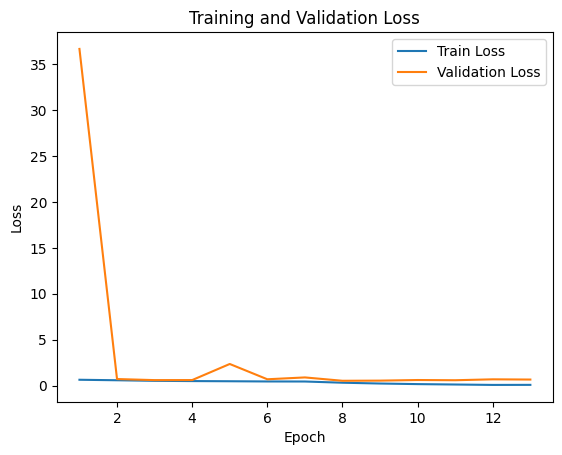

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PretrainedResNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


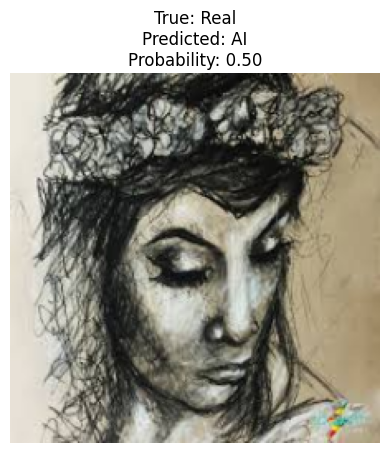

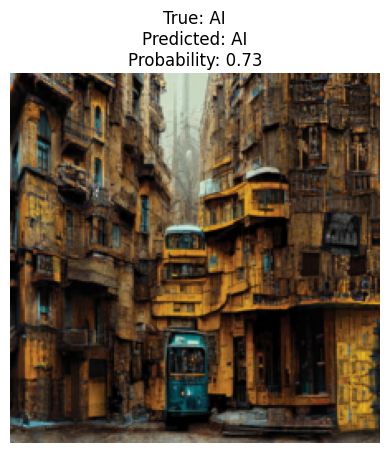

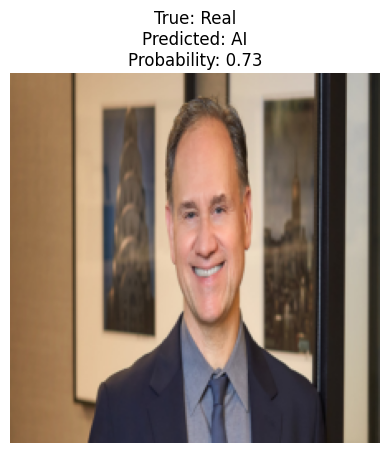

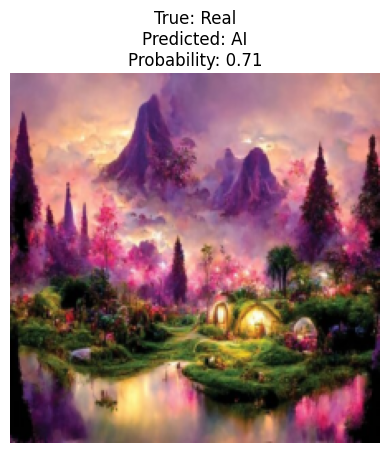

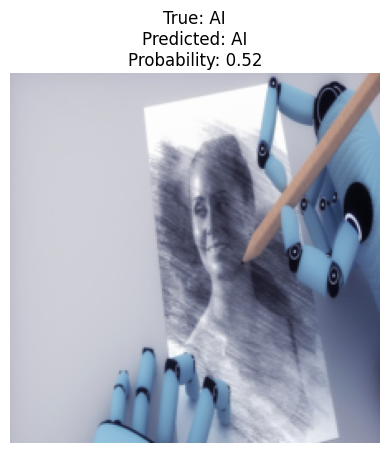

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

def show_image_with_prediction(img_tensor, true_label, predicted_label, probability):
    transform_to_pil = transforms.ToPILImage()
    img = transform_to_pil(img_tensor)

    plt.imshow(img)
    plt.title(f"True: {'AI' if true_label == 1 else 'Real'}\n"
              f"Predicted: {'AI' if predicted_label == 1 else 'Real'}\n"
              f"Probability: {probability:.2f}")
    plt.axis('off')
    plt.show()

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    shown_images = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze(1)
            probabilities = torch.sigmoid(outputs).cpu().numpy() 
            predicted_labels = (probabilities >= 0.5).astype(int)

            for i in range(len(images)):
                if shown_images >= num_images:
                    return
                show_image_with_prediction(
                    img_tensor=images[i+5].cpu(),
                    true_label=labels[i+5].item(),
                    predicted_label=predicted_labels[i],
                    probability=probabilities[i]
                )
                shown_images += 1

visualize_predictions(model, val_loader, device, num_images=11)


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

val_labels = []
val_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (outputs >= 0.5).float()
        val_labels.append(labels.cpu())
        val_preds.append(preds.cpu())

val_labels = torch.cat(val_labels).numpy()
val_preds = torch.cat(val_preds).numpy()

# Метрики
accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.7474
Precision: 0.8365
Recall: 0.7311
F1 Score: 0.7803


In [47]:
test_labels = []
test_preds = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (outputs >= 0.5).float()
        test_labels.append(labels.cpu())
        test_preds.append(preds.cpu())

test_labels = torch.cat(test_labels).numpy()
test_preds = torch.cat(test_preds).numpy()

# Метрики
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/Users/daniyar/notes/projects/ai_image_detector/env/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy: 0.9949
Precision: 0.9976
Recall: 0.9928
F1 Score: 0.9952
